Практическая работа 6 - Атаманчук А.В. КВБО-01-22

In [1]:
from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    HistGradientBoostingClassifier
)
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR = ARTIFACTS_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    """Вычисляет метрики: accuracy, F1, ROC-AUC (если доступны вероятности)"""
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    """Оценивает модель на тестовой выборке и возвращает метрики"""
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    """Сохраняет объект в JSON файл"""
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

## 1. Загрузка данных и первичный анализ

In [3]:
df = pd.read_csv('S06-hw-dataset-01.csv')
print(f"Размер датасета: {df.shape}")
print(f"\nПервые строки:")
df.head()

Размер датасета: (12000, 30)

Первые строки:


,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,...,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,...,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,...,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,...,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,...,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             12000 non-null  int64  
 1   num01          12000 non-null  float64
 2   num02          12000 non-null  float64
 3   num03          12000 non-null  float64
 4   num04          12000 non-null  float64
 5   num05          12000 non-null  float64
 6   num06          12000 non-null  float64
 7   num07          12000 non-null  float64
 8   num08          12000 non-null  float64
 9   num09          12000 non-null  float64
 10  num10          12000 non-null  float64
 11  num11          12000 non-null  float64
 12  num12          12000 non-null  float64
 13  num13          12000 non-null  float64
 14  num14          12000 non-null  float64
 15  num15          12000 non-null  float64
 16  num16          12000 non-null  float64
 17  num17          12000 non-null  float64
 18  num18 

In [5]:
df.describe()

,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.013705,-0.005278,-0.002357,0.038404,-0.006301,-0.865297,-0.702877,-0.290694,-0.008154,...,-0.323083,-1.314833,0.319798,-0.002742,0.027459,0.988750,1.990167,1.506833,36.083833,0.323417
std,3464.24595,2.096534,3.544498,1.004417,2.087318,1.007329,3.888966,1.989513,3.455981,0.996677,...,2.167066,3.731384,2.223649,0.996454,1.882359,0.815687,1.411643,1.121558,25.061218,0.467800
min,1.00000,-8.155181,-14.605579,-4.374043,-7.753301,-3.999332,-15.238402,-7.377252,-13.853627,-3.794637,...,-8.371050,-14.249204,-8.638879,-3.532093,-7.923990,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,-1.423844,-2.303772,-0.685618,-1.374579,-0.676552,-3.532054,-2.064888,-2.597019,-0.683959,...,-1.808969,-3.863063,-1.097700,-0.676150,-1.110822,0.000000,1.000000,0.000000,17.000000,0.000000
50%,6000.50000,-0.047565,0.053348,-0.009186,0.038766,-0.003728,-1.092517,-0.795907,-0.208245,-0.020883,...,-0.383940,-1.393400,0.431804,0.006297,0.279689,1.000000,2.000000,2.000000,30.000000,0.000000
75%,9000.25000,1.422676,2.335937,0.671441,1.484417,0.669269,1.526389,0.522625,2.093169,0.666959,...,1.125140,1.116111,1.853491,0.657478,1.363896,2.000000,3.000000,3.000000,49.000000,1.000000
max,12000.00000,8.610863,16.299709,3.651692,7.571965,4.562115,16.223054,8.006444,13.030011,3.976868,...,7.957847,15.937281,8.102095,3.707905,7.549514,2.000000,4.000000,3.000000,120.000000,1.000000


Распределение целевого признака 'target':
target
0    0.676583
1    0.323417
Name: proportion, dtype: float64

Абсолютные значения:
target
0    8119
1    3881
Name: count, dtype: int64


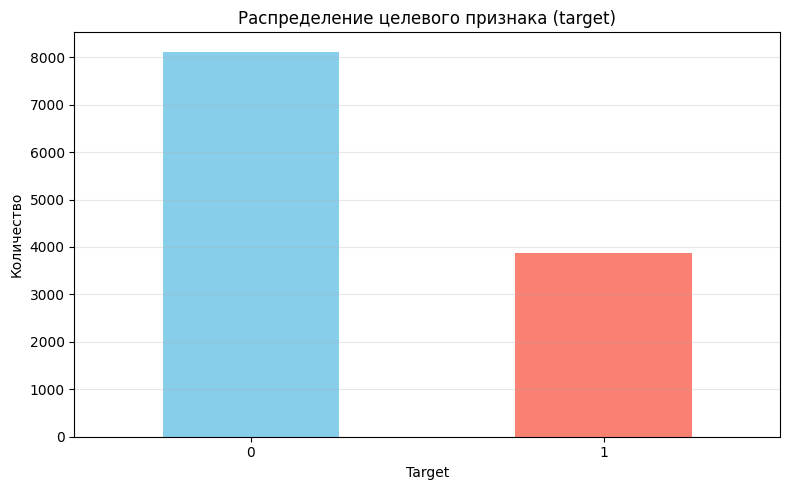

In [6]:
target_dist = df['target'].value_counts(normalize=True)
print("Распределение целевого признака 'target':")
print(target_dist)
print(f"\nАбсолютные значения:")
print(df['target'].value_counts())

plt.figure(figsize=(8, 5))
df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение целевого признака (target)')
plt.xlabel('Target')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
print("Пропущенные значения:")
print(df.isnull().sum().sum())

X = df.drop(columns=['id', 'target'])
y = df['target']

print(f"\nРазмерность матрицы признаков X: {X.shape}")
print(f"Размерность вектора таргета y: {y.shape}")
print(f"\nСписок признаков (первые 10):")
print(list(X.columns)[:10])

Пропущенные значения:
0

Размерность матрицы признаков X: (12000, 28)
Размерность вектора таргета y: (12000,)

Список признаков (первые 10):
['num01', 'num02', 'num03', 'num04', 'num05', 'num06', 'num07', 'num08', 'num09', 'num10']


## 2. Train/Test-сплит и воспроизводимость

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))


Размер обучающей выборки: 9600
Размер тестовой выборки: 2400

Распределение классов в обучающей выборке:
target
0    0.676562
1    0.323437
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
target
0    0.676667
1    0.323333
Name: proportion, dtype: float64


- random_state обеспечивает воспроизводимость результатов
- stratify=y гарантирует, что пропорции классов в train и test одинаковы

## 3. Baseline'ы

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_models = {}  
search_summaries = {}

# Dummy baseline
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, X_test, y_test, "Dummy(most_frequent)"))
best_models["Dummy(most_frequent)"] = dummy

print("Результаты бейзлайн-модели (DummyClassifier):")
for key, value in results[0].items():
    if key != 'model':
        print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


Результаты бейзлайн-модели (DummyClassifier):
accuracy: 0.6767
f1: 0.0000
roc_auc: 0.5000


In [11]:
lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
])

lr_grid = {
    'lr__C': [0.1, 1.0, 10.0, 100.0]
}

lr_search = GridSearchCV(
    lr, lr_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)"))

print("Результаты LogReg(scaled):")
print(f"Лучшие параметры: {lr_search.best_params_}")
print(f"CV ROC-AUC: {lr_search.best_score_:.4f}")
for key, value in results[1].items():
    if key != 'model':
        print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


Результаты LogReg(scaled):
Лучшие параметры: {'lr__C': 1.0}
CV ROC-AUC: 0.8822
accuracy: 0.8275
f1: 0.7076
roc_auc: 0.8747


## 4. Модели недели 6

In [12]:
def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

### 4.1 Decision Tree

In [13]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [1, 5, 10, 20],
    'ccp_alpha': [0.0, 0.001, 0.01]
}

dt_search = run_search("DecisionTree", dt, dt_grid)
print("DecisionTree - Лучшие параметры:")
print(search_summaries["DecisionTree"]["best_params"])
print(f"CV ROC-AUC: {search_summaries['DecisionTree']['best_cv_roc_auc']:.4f}")


DecisionTree - Лучшие параметры:
{'ccp_alpha': 0.0, 'max_depth': None, 'min_samples_leaf': 20}
CV ROC-AUC: 0.9183


### 4.2 Random Forest

In [14]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 0.5]
}

rf_search = run_search("RandomForest", rf, rf_grid)
print("RandomForest - Лучшие параметры:")
print(search_summaries["RandomForest"]["best_params"])
print(f"CV ROC-AUC: {search_summaries['RandomForest']['best_cv_roc_auc']:.4f}")


RandomForest - Лучшие параметры:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}
CV ROC-AUC: 0.9691


### 4.3 HistGradientBoosting

In [15]:
hgb = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True
)

hgb_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, None],
    'max_leaf_nodes': [15, 31, 63]
}

hgb_search = run_search("HistGradientBoosting", hgb, hgb_grid)
print("HistGradientBoosting - Лучшие параметры:")
print(search_summaries["HistGradientBoosting"]["best_params"])
print(f"CV ROC-AUC: {search_summaries['HistGradientBoosting']['best_cv_roc_auc']:.4f}")

HistGradientBoosting - Лучшие параметры:
{'learning_rate': 0.2, 'max_depth': None, 'max_leaf_nodes': 63}
CV ROC-AUC: 0.9734


## 5. Сводка результатов (test)

In [16]:
df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values('roc_auc', ascending=False, na_position='last')
print("Результаты всех моделей на тестовой выборке:")
df_sorted


Результаты всех моделей на тестовой выборке:


,accuracy,f1,roc_auc,model
5,0.929583,0.887558,0.971273,HistGradientBoosting
4,0.925833,0.879240,0.966576,RandomForest
3,0.869167,0.794233,0.909757,DecisionTree
1,0.827500,0.707627,0.874691,LogReg(scaled)
2,0.827500,0.707627,0.874691,LogReg(scaled)
0,0.676667,0.000000,0.500000,Dummy(most_frequent)


In [17]:
best_label = df_sorted.iloc[0]['model']
best_model = best_models[best_label]
best_row = df_sorted.iloc[0]

print(f"Лучшая модель: {best_label}")
print(f"ROC-AUC: {best_row['roc_auc']:.4f}")
print(f"Accuracy: {best_row['accuracy']:.4f}")
print(f"F1: {best_row['f1']:.4f}")


Лучшая модель: HistGradientBoosting
ROC-AUC: 0.9713
Accuracy: 0.9296
F1: 0.8876


## 6. Сохранение артефактов

In [18]:
metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results": df_sorted.to_dict(orient="records")}, metrics_path)
save_json(search_summaries, search_path)

In [19]:
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

## 7. Диагностика: графики

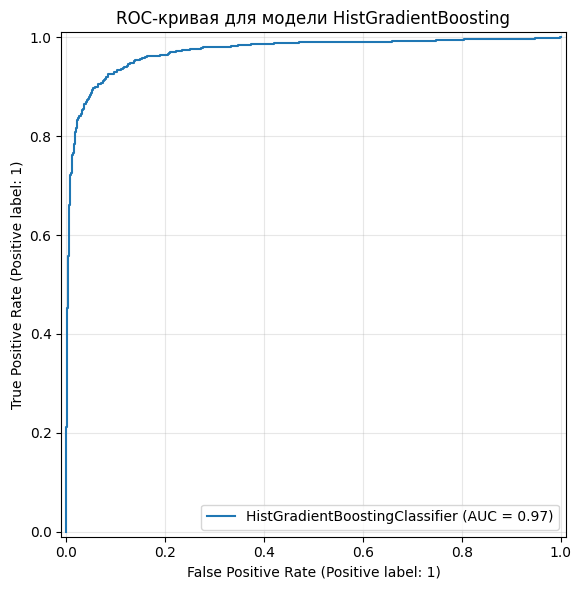

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax)
plt.title(f'ROC-кривая для модели {best_label}')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

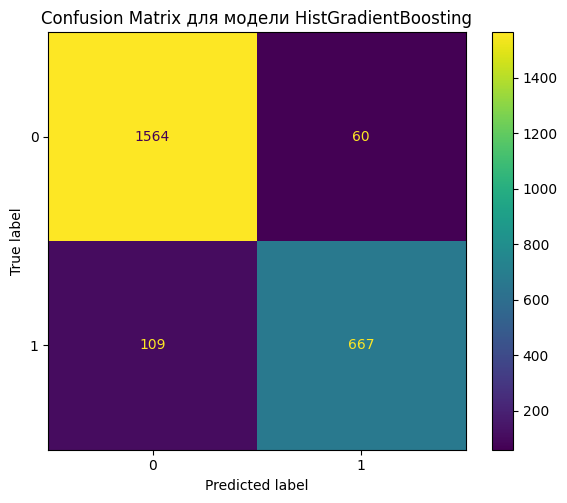

Confusion Matrix:
[[1564   60]
 [ 109  667]]


In [21]:
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, ax=ax)
plt.title(f'Confusion Matrix для модели {best_label}')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion Matrix:")
print(cm)

## 8. Интерпретация: Permutation Importance

In [22]:
perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring='roc_auc',
    n_jobs=-1
)

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
})
importance_df = importance_df.sort_values('importance_mean', ascending=False)

print("Top-15 важных признаков:")
print(importance_df.head(15))

Top-15 важных признаков:
   feature  importance_mean  importance_std
18   num19         0.069383        0.003079
17   num18         0.065791        0.004371
6    num07         0.036083        0.000955
3    num04         0.020302        0.001851
0    num01         0.014740        0.001143
23   num24         0.014148        0.000984
13   num14         0.012676        0.001549
19   num20         0.011081        0.001796
21   num22         0.008858        0.000921
15   num16         0.006190        0.000709
20   num21         0.005676        0.000641
7    num08         0.005444        0.000951
16   num17         0.004766        0.000459
5    num06         0.004598        0.001713
12   num13         0.003385        0.000640


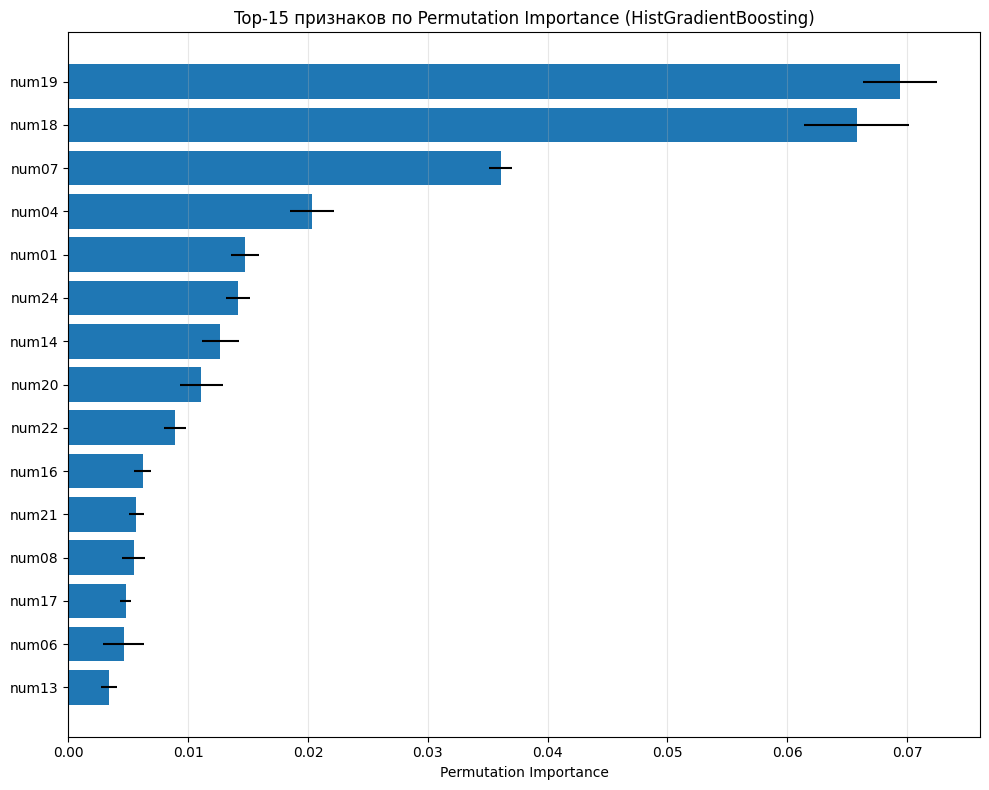

In [23]:
top_n = 15
top_importance = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(top_importance))
ax.barh(y_pos, top_importance['importance_mean'], xerr=top_importance['importance_std'])
ax.set_yticks(y_pos)
ax.set_yticklabels(top_importance['feature'])
ax.invert_yaxis()  # Наиболее важные сверху
ax.set_xlabel('Permutation Importance')
ax.set_title(f'Top-{top_n} признаков по Permutation Importance ({best_label})')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'permutation_importance.png', dpi=150, bbox_inches='tight')
plt.show()